## Download Data

In [ ]:
!pip install tensorflow==2.8.0

In [1]:
!pip install -U --no-cache-dir gdown --pre
# weather-dataset.zip
!gdown --id 1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F

In [ ]:
!unzip weather-dataset.zip

In [2]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Weather Recognition

In [4]:
# list đường dẫn các file ảnh
WEATHER_DATA_PATH = 'dataset'
path_imgs = list(glob.glob(WEATHER_DATA_PATH+'/**/*.jpg'))


In [5]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,rime
1,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,fogsmog
2,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,rainbow
3,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,dew
4,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,sandstorm


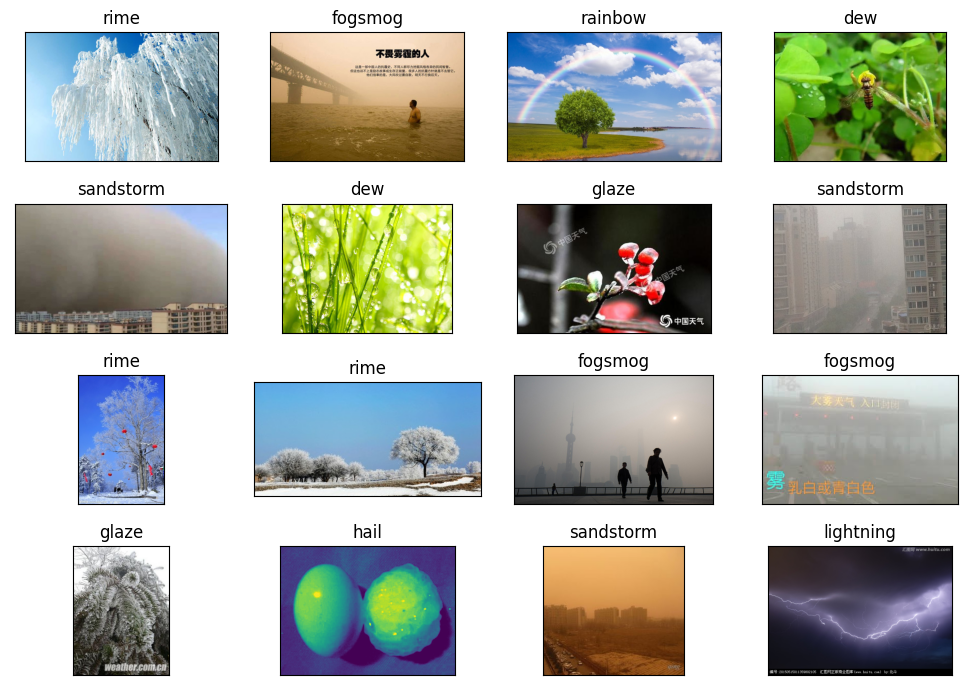

In [6]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

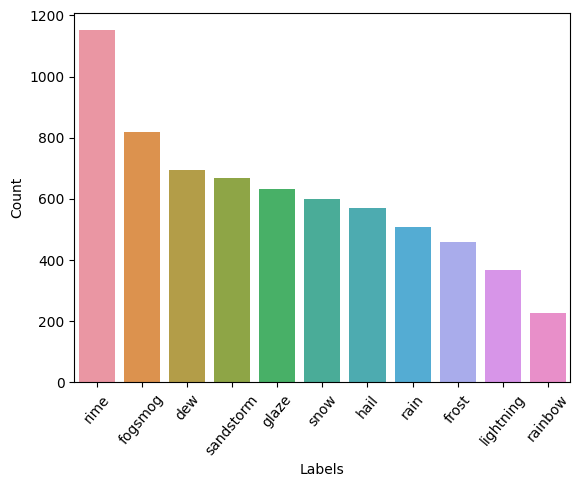

In [7]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [8]:
batch_size = 32
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


2022-12-28 13:23:16.508287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:23:16.527440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:23:16.527536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:23:16.527908: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


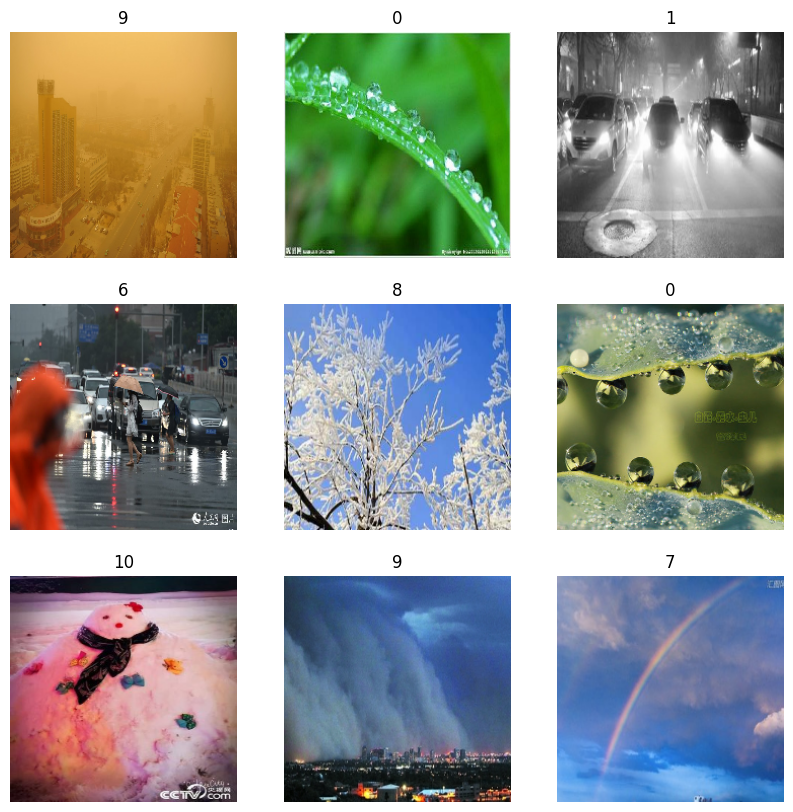

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

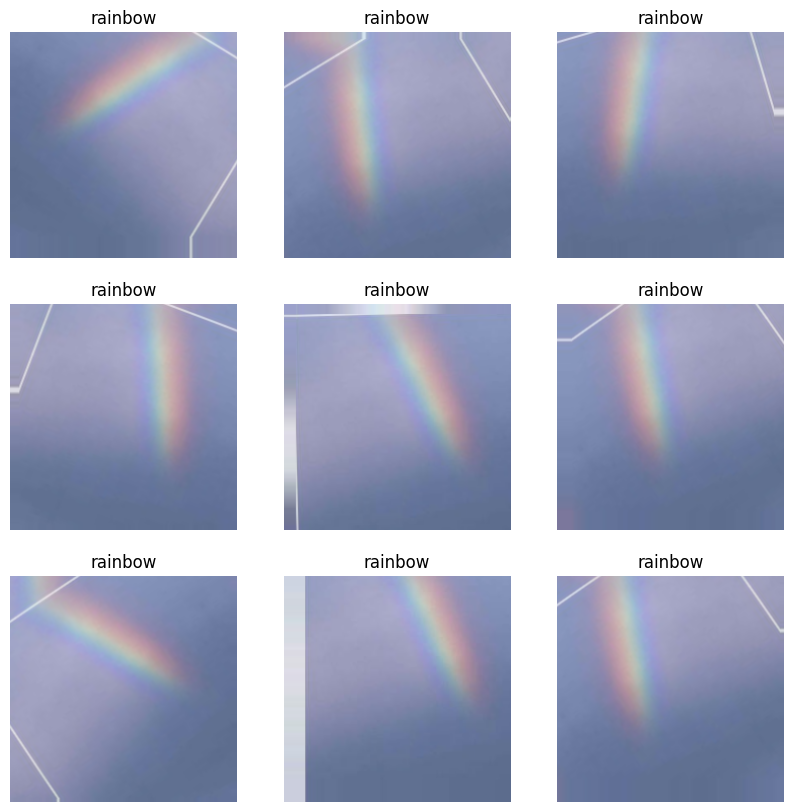

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

## ResNet34

In [15]:
class BuildResNet34():
    def __init__(self):
        pass

    def identity_block(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        skip_connection = layers.add([inputs, x])     
        x = layers.Activation('relu')(skip_connection)
        
        return x
    
    
    def projection_block(self, inputs, filters, strides=2):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides, use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                                 strides=strides, use_bias=False)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
        skip_connection = layers.add([shortcut, x])        
        x = layers.Activation('relu')(skip_connection)
        
        return x
    
    def build_model(self, classes, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        
        # conv1
        x = layers.ZeroPadding2D(padding=((3, 3)))(inputs)
        x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1)))(x)
        x = layers.MaxPooling2D(3, strides=2)(x)
        
        # conv2_X
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return model
        

In [16]:
build_resnet34 = BuildResNet34()
resnet34_model = build_resnet34.build_model(classes=11)

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = resnet34_model(x)
weather_resnet34_model = Model(inputs=image_input, outputs=x)

weather_resnet34_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 11)                21307339  
                                                                 
Total params: 21,307,339
Trainable params: 21,290,315
Non-trainable params: 17,024
_________________________________________________________________


In [17]:
num_epochs = 50

weather_resnet34_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


history = weather_resnet34_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds)

Epoch 1/50


2022-12-28 13:23:20.267903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-12-28 13:23:21.103481: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


172/172 [==============================] - 13s 57ms/step - loss: 1.8033 - accuracy: 0.4301 - val_loss: 4.5610 - val_accuracy: 0.1115
Epoch 2/50
172/172 [==============================] - 9s 55ms/step - loss: 1.2204 - accuracy: 0.5811 - val_loss: 3.1314 - val_accuracy: 0.2536
Epoch 3/50
172/172 [==============================] - 10s 55ms/step - loss: 1.1159 - accuracy: 0.6160 - val_loss: 1.7148 - val_accuracy: 0.4461
Epoch 4/50
172/172 [==============================] - 10s 55ms/step - loss: 1.0455 - accuracy: 0.6415 - val_loss: 1.1654 - val_accuracy: 0.6173
Epoch 5/50
172/172 [==============================] - 10s 55ms/step - loss: 1.0018 - accuracy: 0.6530 - val_loss: 1.1570 - val_accuracy: 0.6254
Epoch 6/50
172/172 [==============================] - 10s 56ms/step - loss: 0.9463 - accuracy: 0.6767 - val_loss: 1.2260 - val_accuracy: 0.6028
Epoch 7/50
172/172 [==============================] - 10s 55ms/step - loss: 0.9388 - accuracy: 0.6758 - val_loss: 1.1353 - val_accuracy: 0.6305
Epoc

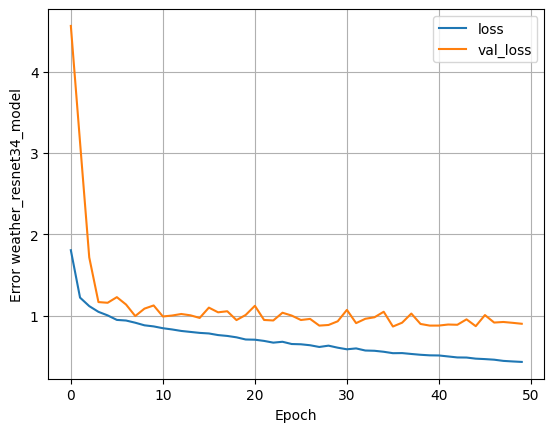

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error weather_resnet34_model')
plt.legend()
plt.grid(True)

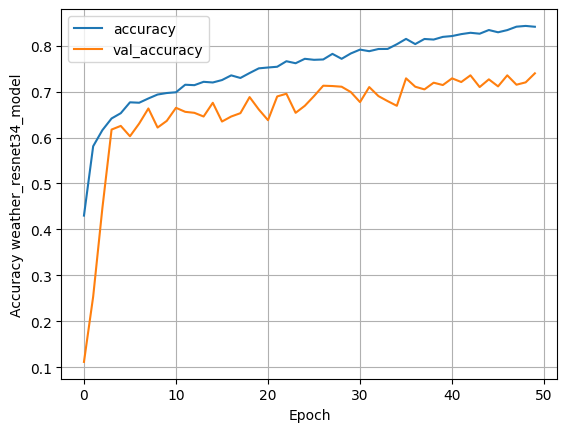

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy weather_resnet34_model')
plt.legend()
plt.grid(True)

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.464393,0.829144,1.005803,0.711370,45
46,0.457162,0.833880,0.913781,0.735423,46
47,0.442448,0.841348,0.920749,0.715015,47
48,0.435596,0.842987,0.910524,0.720117,48
49,0.429695,0.841166,0.898771,0.739796,49
